# Selenium + Requests 조합
bigkinds <br>

In [1]:
# 빅카인즈 홈페이지에서 상세검색
# https://www.bigkinds.or.kr/
# 검색어 ㅡ 무역전쟁
# 검색기간 :2021-01-01에서 현재
# 검색범위 바이그램 지정  (상세검색 - 검색어처리)
# 언론사 :중앙지, 지역종합지 
# 
# 검색한결과의
#   기사제목, 신문사, 일자, 본문  -> 결과물

In [ ]:
# 검색 단계까지는 selenium 으로
# 각 기사는 requests + BS4 로

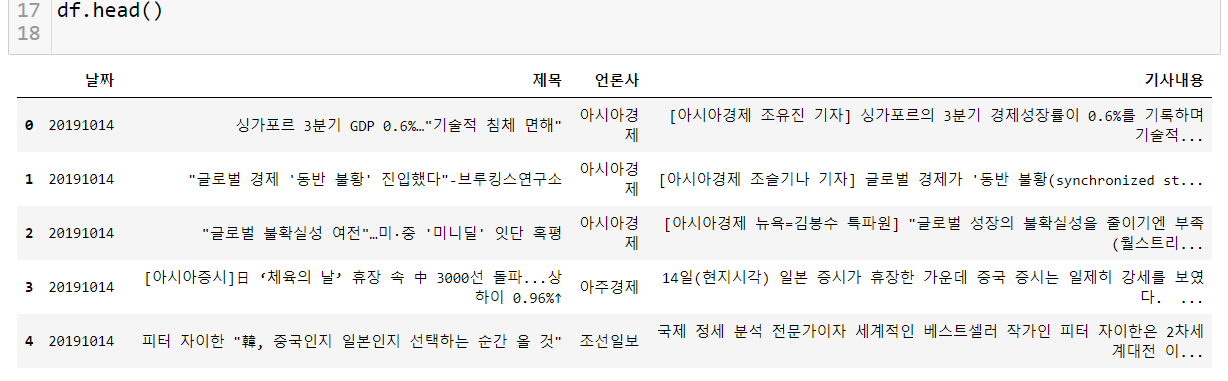

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
driver_path = r'C:\DevRoot\dataset\bin\chromedriver.exe'
driver = webdriver.Chrome(driver_path)

In [3]:
driver.get("https://www.bigkinds.or.kr/")

In [4]:
# 검색어 ㅡ 무역전쟁
# 언론사 :중앙지, 지역종합지 선택
driver.find_element_by_css_selector("#total-search-key").send_keys("무역전쟁")
driver.find_element_by_css_selector(".btn-srchDetail").click()
driver.find_element_by_id('중앙지').send_keys(Keys.SPACE)
driver.find_element_by_id('지역종합지').send_keys(Keys.SPACE)
driver.find_element_by_css_selector(".tab-btn.search-tab_group").click()

In [5]:
# 검색기간 :2021-01-01에서 현재
date = driver.find_element_by_css_selector("#search-begin-date")
date.send_keys(Keys.CONTROL + "a")
date.send_keys(Keys.DELETE)
date.send_keys("2021-01-01")
driver.find_element_by_css_selector(".tab-btn.tab5").click()

In [6]:
# 검색범위 바이그램 지정  (상세검색 - 검색어처리)
from selenium.webdriver.support.select import Select
selects = Select(driver.find_element_by_css_selector("#search-filter-type"))
selects.select_by_visible_text('바이그램')
driver.find_element_by_css_selector(".btn-primary.news-search-btn").click()

In [7]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

In [13]:
url = 'https://www.bigkinds.or.kr/api/news/search.do'
jsonstr = '{"indexName":"news","searchKey":"무역전쟁","searchKeys":[{}],"byLine":"","searchFilterType":"2","searchScopeType":"1","searchSortType":"date","sortMethod":"date","mainTodayPersonYn":"","startDate":"2021-01-01","endDate":"2021-06-02","newsIds":[],"categoryCodes":[],"providerCodes":["01100101","01100201","01100301","01100401","01100501","01100611","01100701","01100801","01100901","01101001","01101101","01300101","01300201","01200101","01500151","01500051","01500301","01200201","01600201","01600301","01500401","01500501","01400201","01500601","01600501","01500701","01500801","01500901","01600801","01601001","01601101","01700101","01400351","01400401","01400501","01400551","01400601","01400701","01700201"],"incidentCodes":[],"networkNodeType":"","topicOrigin":"","editorialIs":false}'
jsondata = json.loads(jsonstr)  # json 문자열 -> 파이썬 객체(list, dict)로 변환
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36',
    'Referer': 'https://www.bigkinds.or.kr/v2/news/search.do'
}
response = requests.post(url, json=jsondata, headers=headers)
response

<Response [200]>

In [15]:
data = response.json()
data['resultList'][0]['NEWS_ID']

'01100501.20210531121007004'

In [20]:
data['totalCount']

187

In [24]:
newsId = data['resultList'][0]['NEWS_ID']
url2 = f'https://www.bigkinds.or.kr/news/detailView.do?docId={newsId}&returnCnt=1&sectionDiv=1000'.format(newsId = newsId)
        
headers2 = {
    'Referer': 'https://www.bigkinds.or.kr/v2/news/search.do',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36'
}
        
response2 = requests.get(url2, headers=headers2)
doc_data = response2.json()

doc_dic = {
     '날짜' : doc_data['detail']['DATE'],
     '제목' : doc_data['detail']['TITLE'],
     '언론사' : doc_data['detail']['PROVIDER'],
     '기사내용' : doc_data['detail']['CONTENT'].replace('<br/>', '')
}
doc_dic

{'날짜': '20210531',
 '제목': '산업재편 지연·정책 실패·고비용 고착…대기업도 고용 못늘려',
 '언론사': '문화일보',
 '기사내용': '■ ‘고용·매출 동반부진’ 악순환 삼성 등 4대 그룹 고용 제외땐 지난해 일자리 감소폭 더 늘어 올 1분기도 전년비 1만개 줄어 매출, 2017년 수준 이하 감소 순이익도 절반 이하 곤두박질 적자 그룹도 6곳으로 늘어나30대 그룹(총 1419개사)의 최근 5년간 고용·실적은 그동안 질이 높고 순증을 해왔다고 안심을 하던 양질의 고용 섹터조차 충격을 받고 있음을 고스란히 보여주고 있다. 전체 상시 종업원 수는 130만 명 안팎에 머물고 순이익은 2년 새 반 토막 수준으로 떨어지는 등 ‘고용·실적의 동반 부진의 고착화’ 현상이 뚜렷했다. 올 1분기에도 대기업 정규직 일자리 수가 1년여 전에 비해 1만 개 이상 감소하는 등 일자리 질 악화 현상은 이어지고 있다. 자칫 고용과 성장 모두 동력이 고갈될 수 있다는 우려가 경제계와 학계에서 나온다. 신종 코로나바이러스 감염증(코로나19) 사태 종식 기대감에 국내외 경제 회복 전망이 제기되지만 규제 개혁을 통해 신사업 진출의 물꼬를 트고, 혁신 기업을 대기업 수준으로 키워내지 못하면 고용·성장 동반 부진의 늪에서 좀처럼 벗어나기 어려울 것으로 분석된다.◇일자리 질 악화=31일 문화일보와 한국경제연구원이 30대 그룹의 올해 공정거래위원회 신고 자료를 분석한 결과, 이들 그룹의 지난 5년 동안(2015~2020년) 연평균 고용 증가율은 0.6%에 그쳤다. 지난해 상시 종업원 수는 오히려 1년 새 1.4%(1만8377명) 감소했다. 기계·설비, 항공, 유통, 정유, 철강 업종에 속한 그룹사 대부분은 상시 종업원 수가 5년 새에 5~30%가량 줄어든 것으로 파악됐다. 삼성·현대차·SK·LG 등 4대 그룹의 지난해 전체 상시 종업원 수 규모가 5년 전보다 약 7.9% 증가한 5만1000여 명 늘면서 지난해 감소 폭을 줄일 수 있었던 것으로 보인다. 삼성과 현대차, SK, LG 